# **Multiple Latent-Layer Variational Autoencoder**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [ ]:
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import Model, Sequential
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Conv2DTranspose,\
                                    Reshape, ReLU, LeakyReLU,BatchNormalization, Lambda, \
                                    UpSampling2D, Softmax, Input, Dropout, AvgPool2D, Concatenate, \
                                    LocallyConnected2D, SpatialDropout2D, Activation, InputLayer

import os

In [ ]:
tf.__version__

'2.13.0'

## **Data loading and preprocessing MNIST**
I've loaded the MNIST dataset (train and test), separated pixels from labels then normalized in a [0,1] scale

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/prml/mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/prml/mnist_test.csv')

In [ ]:
image_class = data.iloc[:, 0].copy()
images = data.iloc[:, 1:].copy()
del data
gc.collect()
test_image_class = test.iloc[:, 0].copy()
test_images = test.iloc[:, 1:].copy()
del test
gc.collect()

0

In [ ]:
images = images.astype('float32')
images = images.values / images.max().max()
test_images = test_images.astype('float32')
test_images = test_images.values / test_images.max().max()

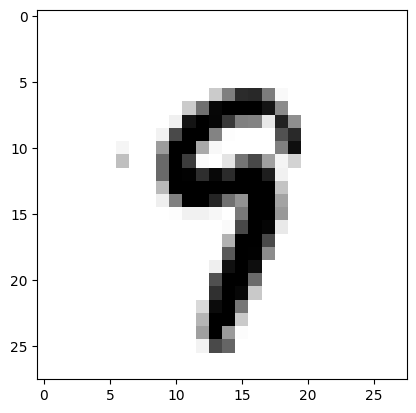

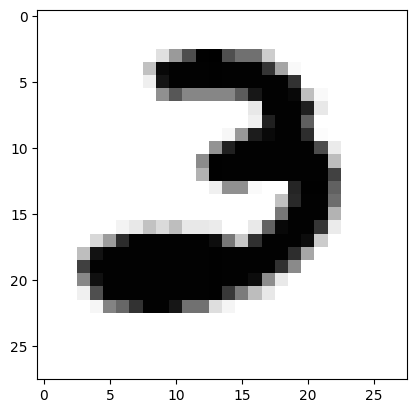

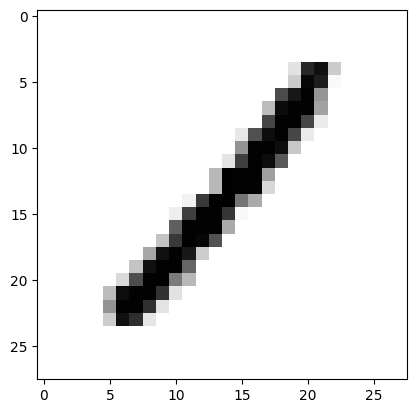

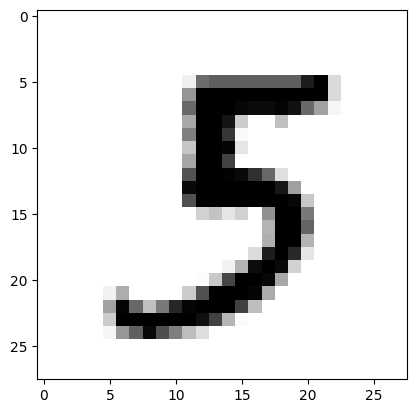

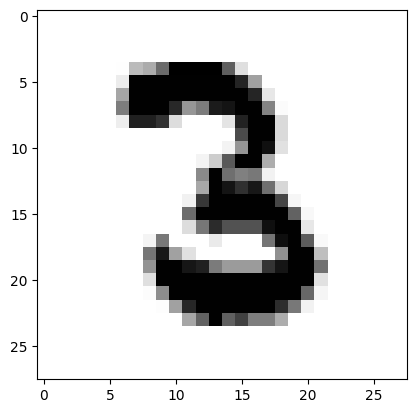

In [ ]:
for i in np.random.randint(0,  len(test_images)-1, 5):
    plt.imshow(test_images[i].reshape((28,28)), cmap='gray_r')
    plt.show()

## **Model Architecture**

## **Normal Stocastic layer**

The class constructor allows to:

specify the size of the multivariate normal

set prior mean and variance
add to loss kl divergence and its coefficient

add to loss MMD (Maximum Mean Discrepancy), its coefficient and the kernel (by default rbf). The class implements itself yet both linear and rbf kernel


In [ ]:
class NormalVariational(tf.keras.layers.Layer):

    def __init__(self, size, mu_prior=0., sigma_prior=1., add_kl=True, coef_kl = 1.0, add_mmd=False, lambda_mmd=1.0, kernel_f=None, name=None, show_posterior=True):
        super().__init__(name=name)
        self.mu_layer = tf.keras.layers.Dense(size) #creates dense layer with size number of units and outputs mean of normal distribution
        self.sigma_layer = tf.keras.layers.Dense(size) #same as above but outputs log variation of normal distribution
        self.add_kl = add_kl #variable for determining the layer will include KL divergence regularization term
        self.mu_prior = tf.constant(mu_prior, dtype=tf.float32, shape=(size,)) #constant tensor for representing the prior mean of distribution
        self.sigma_prior = tf.constant(sigma_prior, dtype=tf.float32, shape=(size,))  #constant tensor for representing the prior standard deviation of distribution
        self.show_posterior = show_posterior #for determining whether to display the posterior during training
        self.coef_kl = tf.Variable(coef_kl, trainable=False, name='coef_kl') #represents the coefficient applied to the KL divergence term
        self.add_mmd = add_mmd #determines whether to include maximum mean discrepancy (MMD) regularization
        if kernel_f is None:
            self.kernel_f = self._rbf
        else:
            self.kernel_f = kernel_f
        self.lambda_mmd = lambda_mmd #represents the coefficient applied to the MMD regularization term

    #Function for calculating the radial basis function(RBF) kernel between two input tensors
    def _rbf(self, x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1])) #creates a tensor wih [x_size, y_size, dim] dimensions
        tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1])) #creates a tensor wih [x_size, y_size, dim] dimensions

        #finally returns the computed RBF kernel, a tensor of shape [x_size, y_size]
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

    #Function for calculating the linear kernel between two tensors
    def _linear(self, x,y):
        return tf.reduce_sum(tf.multiply(x,y))

    #Function for calculating the KL divergence loss between two normal distributions
    def add_kl_divergence(self, mu1, sigma1, mu2, sigma2):
            logsigma1, logsigma2 = tf.math.log(sigma1), tf.math.log(sigma2)
            mu_diff = mu1 - mu2
            kl = self.coef_kl * \
                tf.reduce_sum(logsigma1 - logsigma2 - 1. + (sigma2 + tf.square(mu_diff)) / sigma1, axis=1)
            kl = tf.reduce_mean(kl)
            self.add_loss(kl)
            # self.add_metric(kl, 'mean', 'kl_divergence')

    def call(self, inputs):
        mu = self.mu_layer(inputs)
        log_sigma =  self.sigma_layer(inputs)
        sigma_square = tf.exp(log_sigma)
        if self.add_kl:
            self.add_kl_divergence(mu, sigma_square, self.mu_prior, self.sigma_prior)
        if self.show_posterior:
            self.add_metric(mu, 'mu_posteror')
            self.add_metric(sigma_square, 'sigma^2_posterior')
        z = mu + sigma_square * tf.random.normal(tf.shape(sigma_square))
        if self.add_mmd:
            z_prior = tfp.distributions.MultivariateNormalDiag(self.mu_prior, self.sigma_prior).sample(tf.shape(z)[0])
            print(z_prior)
            print(z)
            k_prior = self.kernel_f(z_prior, z_prior)
            k_post = self.kernel_f(z, z)
            k_prior_post = self.kernel_f(z_prior, z)
            mmd = tf.reduce_mean(k_prior) + tf.reduce_mean(k_post) - 2 * tf.reduce_mean(k_prior_post)
            mmd = tf.multiply(self.lambda_mmd,  mmd, name='mmd')
            self.add_loss(mmd)
            self.add_metric(mmd, 'mmd')
        return z

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

9863

In [ ]:
def make_encoder(latent_size):
    droput_rate = 0.05
    inputs = Input((28,28,1))
    with tf.name_scope('h_1'):
        h_1_layers = Sequential([
            Input((28, 28, 1)),
            Conv2D(8, 3),
            BatchNormalization(trainable=False),
            ReLU(),
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            SpatialDropout2D(droput_rate),
            ReLU()], name='h_1')
        h_1 = h_1_layers(inputs)
        h_1_flatten = Flatten()(h_1)
    with tf.name_scope('h_2'):
        h_2_layers = Sequential([
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            ReLU(),
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            SpatialDropout2D(droput_rate),
            ReLU()], name='h_2')
        h_2 = h_2_layers(h_1)
        h_2_flatten = Flatten()(h_2)
    with tf.name_scope('h_3'):
        h_3_layers = Sequential([
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            ReLU(),
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            SpatialDropout2D(droput_rate),
            ReLU()], name='h_3')
        h_3 = h_3_layers(h_2)
        h_3_flatten = Flatten()(h_3)
    return Model(inputs, [h_1_flatten, h_2_flatten, h_3_flatten], name='encoder')

In [ ]:
def make_decoder(latent_dim1, latent_dim2, latent_dim3):
    z_1_input, z_2_input, z_3_input = Input((latent_dim1,), name='z_1'), Input((latent_dim2,), name='z_2'), Input((latent_dim3,), name='z_3')

    with tf.name_scope('z_tilde_3'):
        z_3 = Dense(1024, activation='relu')(z_3_input)
        z_tilde_3_layers = Sequential([
            Dense(1024),
            BatchNormalization(trainable=False),
            ReLU()] * 3, name='z_tilde_3')
        z_tilde_3 = z_tilde_3_layers(z_3)

    with tf.name_scope('z_tilde_2'):
        z_2 = Dense(128, activation='relu')(z_2_input)
        z_tilde_2_layers = Sequential([
            Dense(128),
            BatchNormalization(trainable=False),
             ReLU()] * 3, name='z_tilde_2')
        input_z_tilde_2 = Concatenate()([z_tilde_3, z_2])
        z_tilde_2 =  z_tilde_2_layers(input_z_tilde_2)

    with tf.name_scope('z_tilde_1'):
        z_1 = Dense(128, activation='relu')(z_1_input)
        z_tilde_1_layers = Sequential([
            Dense(128),
            BatchNormalization(trainable=False),
             ReLU()] * 3, name='z_tilde_1')
        input_z_tilde_1 = Concatenate()([z_tilde_2, z_1])
        z_tilde_1 =  z_tilde_1_layers(input_z_tilde_1)

    with tf.name_scope('decoder'):
        decoder = Reshape((2,2,32))(z_tilde_1)
        decoder = UpSampling2D(2)(decoder) #4x4
        decoder = Conv2D(32, 3)(decoder) #2x2
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = Activation(tf.nn.crelu)(decoder)
        decoder = UpSampling2D(4)(decoder) #8x8
        decoder = Conv2D(16, 3)(decoder) #6x6
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = Activation(tf.nn.crelu)(decoder)
        decoder = UpSampling2D(2)(decoder) #12x12
        decoder = Conv2D(8, 3)(decoder) #10x10
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = Activation(tf.nn.crelu)(decoder)
        decoder = UpSampling2D(2)(decoder) #20x20
        decoder = Conv2D(4, 5)(decoder) #16x16
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = LeakyReLU()(decoder)
        decoder = UpSampling2D(2)(decoder) #32x32
        decoder = Conv2D(1, 5)(decoder) #28x28
        decoder = Activation('sigmoid')(decoder)
    return Model([z_1_input, z_2_input, z_3_input], decoder, name='decoder')


### **Using MMD**

In [ ]:
def make_vlae(latent_size):
    with tf.name_scope('encoder'):
        encoder = make_encoder(latent_size)
    with tf.name_scope('decoder'):
        decoder = make_decoder(latent_size, latent_size, latent_size)
    inputs = Input((28,28,1))
    h_1, h_2, h_3 = encoder(inputs)
    z_1 = NormalVariational(latent_size, add_kl=False, coef_kl=0.0, add_mmd=True, lambda_mmd=1., name='z_1_latent')(h_1)
    z_2 = NormalVariational(latent_size, add_kl=False, coef_kl=0.0, add_mmd=True, lambda_mmd=1., name='z_2_latent')(h_2)
    z_3 = NormalVariational(latent_size, add_kl=False, coef_kl=0.0, add_mmd=True, lambda_mmd=10., name='z_3_latent')(h_3)

    decoded = decoder([z_1, z_2, z_3])
    vlae = Model(inputs, decoded, name='vlae')
    return vlae

In [ ]:
latent_size = 2
vlae = make_vlae(latent_size)

Tensor("z_1_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("z_1_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("z_2_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("z_2_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("z_3_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("z_3_latent/add:0", shape=(None, 2), dtype=float32)


In [ ]:
vlae.summary()

Model: "vlae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 9216),               10880     ['input_3[0][0]']             
                              (None, 6400),                                                       
                              (None, 4096)]                                                       
                                                                                                  
 z_1_latent (NormalVariatio  (None, 2)                    36869     ['encoder[0][0]']             
 nal)                                                                                          

In [ ]:
def flatten_binary_crossentropy(x,xhat):
    return 10 * tf.losses.binary_crossentropy(Flatten()(x), Flatten()(xhat))

vlae.compile(tf.keras.optimizers.Adam(), flatten_binary_crossentropy, metrics=['accuracy'])

## **Training**

If you create a kernel from the output of this one you can use tensorboard to visualize the learning of the model

The learning rate is log uniform between 0.0012 and 0.00001; before i've tried higher lr but the convergence was worse

EarlyStopping if the validation loss doesn't improve for 15 epochs of 0.001
100 epochs, batch_size=256

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
tb = TensorBoard(write_grads=True, write_images=False, write_graph=True, histogram_freq=2)
es = EarlyStopping(min_delta=0.001, patience=15)

In [ ]:
epochs = 100
lr_epochs = 10 ** np.linspace(-2.9, -4, epochs)
lrsched = LearningRateScheduler(lambda i: lr_epochs[i])

In [ ]:
images = images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

In [ ]:
history=vlae.fit(images, images, batch_size=256, epochs=epochs, callbacks=[lrsched, tb, es], validation_data=(test_images, test_images))

Epoch 1/100
Tensor("vlae/z_1_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_1_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_3_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_3_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_1_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_1_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_ma

In [ ]:
tf.saved_model.save(vlae, 'vinay_vlae')

Tensor("vlae/z_1_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_1_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_3_latent/MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_3_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("add:0", shape=(None, 2), dtype=float32)
Tensor("MultivariateNormalDiag/sample/chain_of_shift_of_scale_matvec_linear_operator/forward/shift/forward/add:0", shape=(No

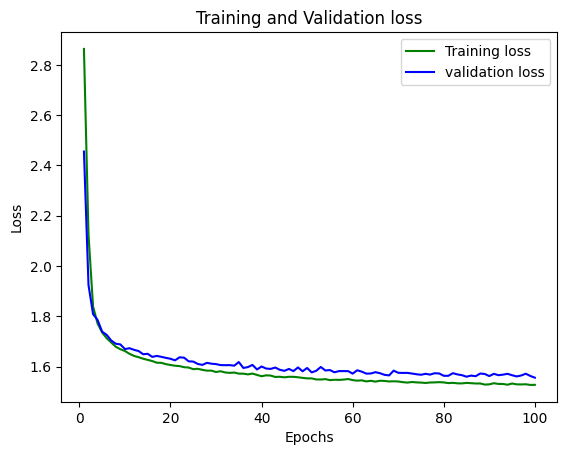

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

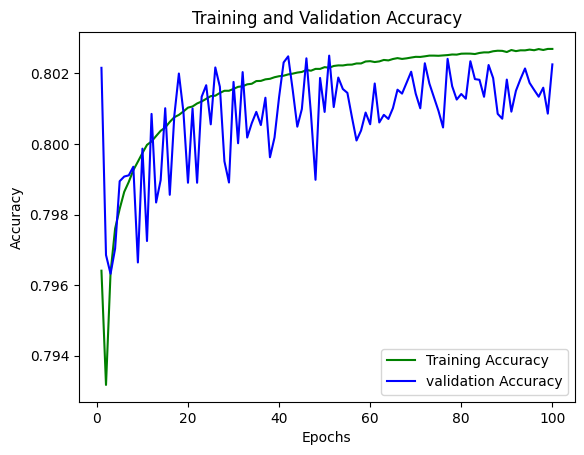

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

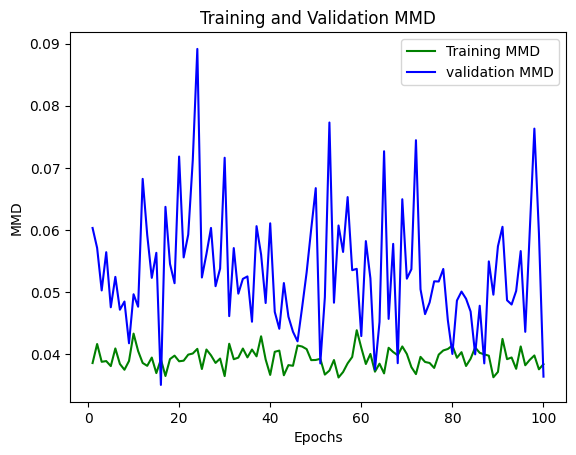

In [ ]:
mmd_train = history.history['mmd']
mmd_val = history.history['val_mmd']
epochs = range(1,101)
plt.plot(epochs, mmd_train, 'g', label='Training MMD')
plt.plot(epochs, mmd_val, 'b', label='validation MMD')
plt.title('Training and Validation MMD')
plt.xlabel('Epochs')
plt.ylabel('MMD')
plt.legend()
plt.show()

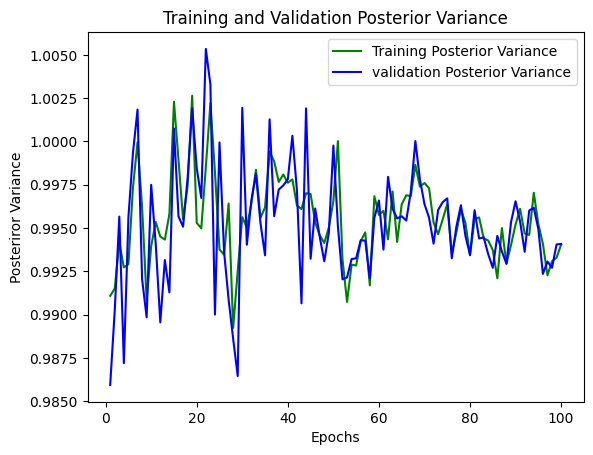

In [ ]:
post_train = history.history['sigma^2_posterior']
post_val = history.history['val_sigma^2_posterior']
epochs = range(1,101)
plt.plot(epochs, post_train, 'g', label='Training Posterior Variance')
plt.plot(epochs, post_val, 'b', label='validation Posterior Variance')
plt.title('Training and Validation Posterior Variance')
plt.xlabel('Epochs')
plt.ylabel('Posteriror Variance')
plt.legend()
plt.show()

## **Output Image Generation**

In order to generate is sufficient sample from the prior (in my case a N(0,1)) three times because there are three latent variable in this model
Then feed into the VLAE-decoder this three random sampled values

In [ ]:
sample = [np.random.multivariate_normal([0] * latent_size, np.diag([1] * latent_size), 20)] * 3

In [ ]:
generated = vlae.get_layer('decoder').predict(sample)

1/1 [==============================] - 0s 233ms/step


In [ ]:
generated = generated.reshape((20, 28, 28))

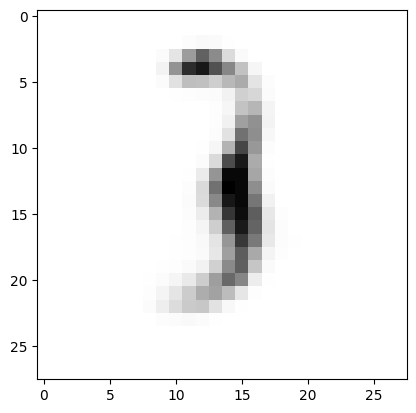

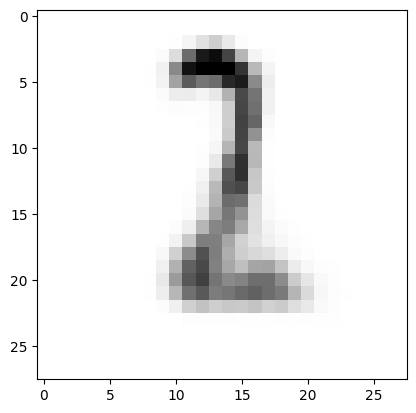

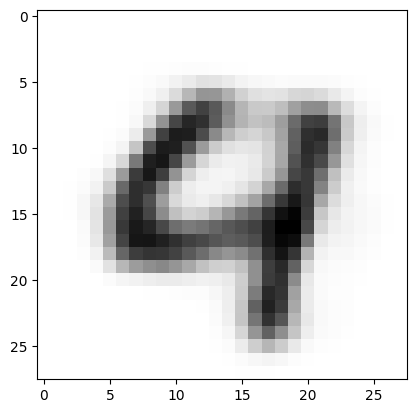

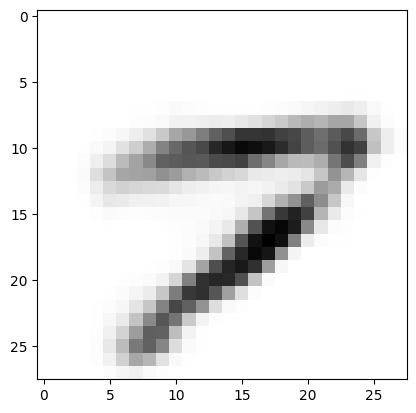

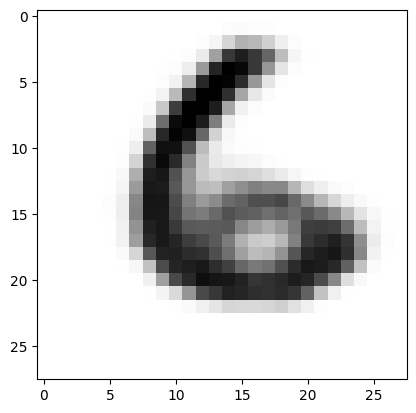

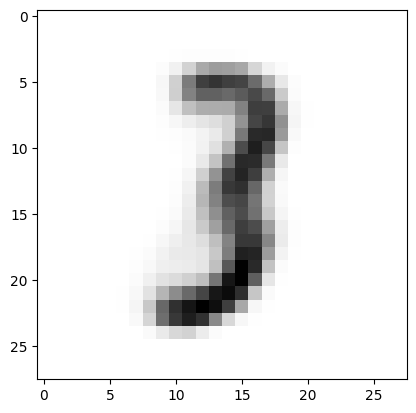

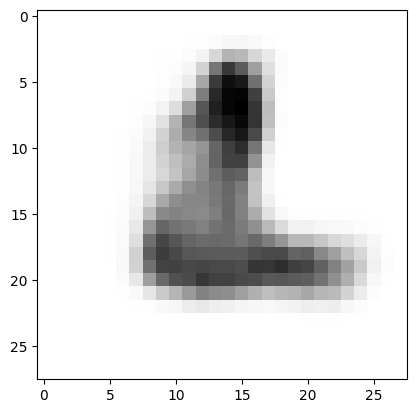

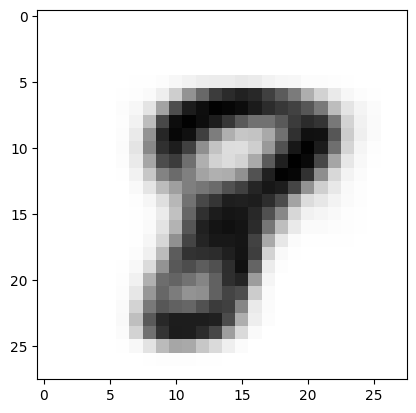

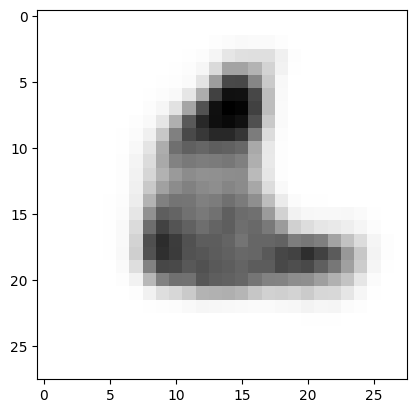

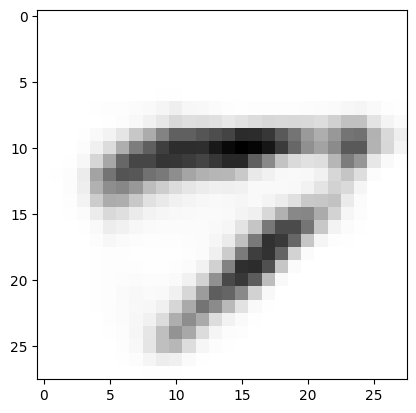

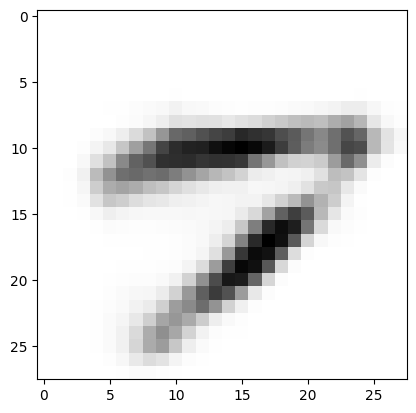

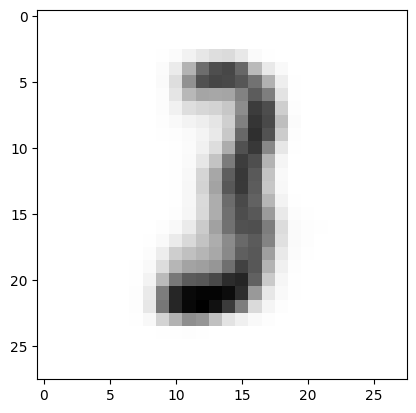

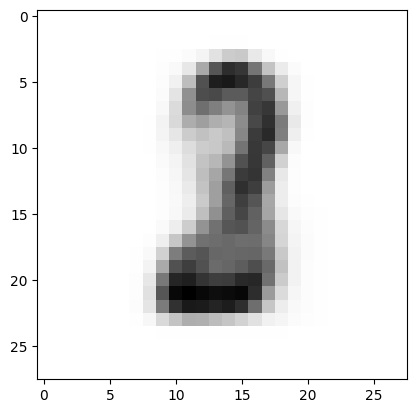

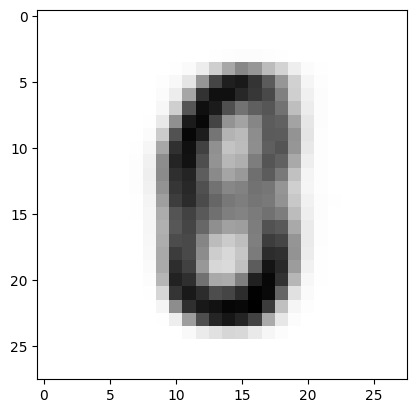

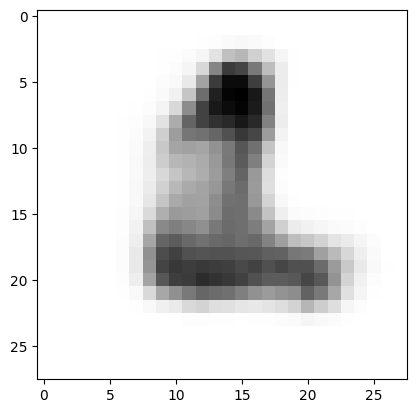

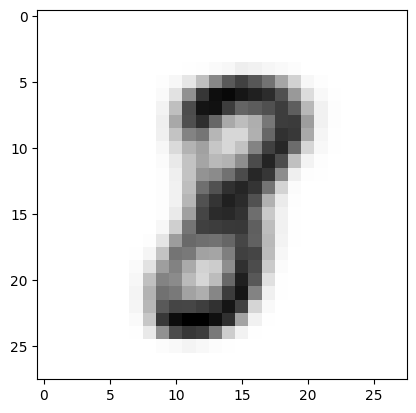

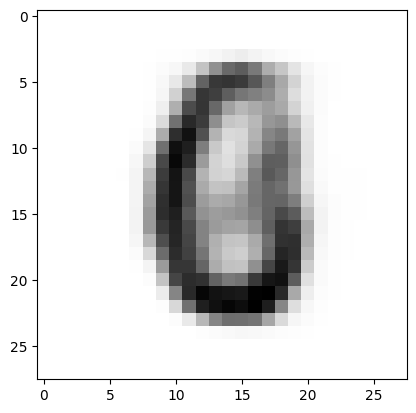

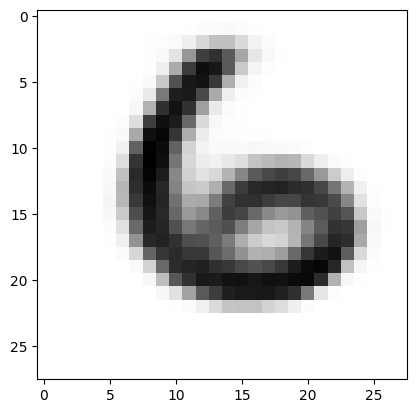

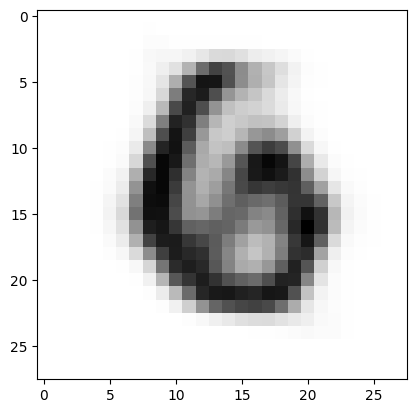

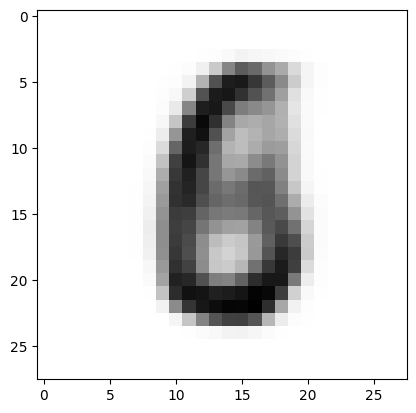

In [ ]:
for i in range(20):
    img = generated[i, :, :]
    plt.imshow(img, cmap='gray_r')
    plt.show()

In [ ]:
from skimage.metrics import mean_squared_error, structural_similarity
from skimage.transform import resize

# Resize generated images to match the input image dimensions
resized_generated = np.zeros_like(images)
for i in range(len(generated)):
    resized_generated[i] = resize(generated[i], images[i].shape)

# Calculate MSE
mse = mean_squared_error(images, resized_generated)

# Calculate SSIM
ssim = structural_similarity(images, resized_generated, multichannel=True)

# Print the calculated accuracy metrics
print(f"MSE: {mse}")
print(f"SSIM: {ssim}")


<ipython-input-33-7d24260a586f>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(images, resized_generated, multichannel=True)


MSE: 0.11199875311580877
SSIM: 0.0573197677731514


## **Using KL Divergence**

In [ ]:
def make_vlae(latent_size):
    with tf.name_scope('encoder'):
        encoder = make_encoder(latent_size)
    with tf.name_scope('decoder'):
        decoder = make_decoder(latent_size, latent_size, latent_size)
    inputs = Input((28,28,1))
    h_1, h_2, h_3 = encoder(inputs)
    z_1 = NormalVariational(latent_size, add_kl=True, coef_kl=1., add_mmd=False, lambda_mmd=0.0, name='z_1_latent')(h_1)
    z_2 = NormalVariational(latent_size, add_kl=True, coef_kl=1., add_mmd=False, lambda_mmd=0.0, name='z_2_latent')(h_2)
    z_3 = NormalVariational(latent_size, add_kl=True, coef_kl=10., add_mmd=False, lambda_mmd=0.0, name='z_3_latent')(h_3)

    decoded = decoder([z_1, z_2, z_3])
    vlae = Model(inputs, decoded, name='vlae')
    return vlae

In [ ]:
latent_size = 2
vlae_kl = make_vlae(latent_size)

In [ ]:
vlae_kl.summary()

Model: "vlae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 9216),               10880     ['input_6[0][0]']             
                              (None, 6400),                                                       
                              (None, 4096)]                                                       
                                                                                                  
 z_1_latent (NormalVariatio  (None, 2)                    36869     ['encoder[0][0]']             
 nal)                                                                                          

In [ ]:
def flatten_binary_crossentropy(x,xhat):
    return 10 * tf.losses.binary_crossentropy(Flatten()(x), Flatten()(xhat))

vlae_kl.compile(tf.keras.optimizers.Adam(), flatten_binary_crossentropy,  metrics=['accuracy'])

KL Warm Up

Keras Callback that implements KL Warm Up for stocastic layers.
Unfortunately the current implementation of this callback is code dependent because use the pre-defined names of stochastic layers to find they


Basically the KL Warm Up constist in set the coefficient before KL divergence to 0 on the first epochs in order to allow the model to properly learn the encoder/decoder part. Then after a specified epoch the coefficient starts to increase until a maximum

All this parameters can be setted in the constructor of this class

In [ ]:
class KLWarmUp(tf.keras.callbacks.Callback):

    def __init__(self, vlae, start_epoch = 1, max_value = 1.0, delta = 0.05):
        self.start_epoch = start_epoch
        self.max_value = 1.0
        self.delta = delta
        self.epoch = 0
        self.vlae = vlae

    def on_epoch_end(self, *args, **kwargs):
        self.epoch += 1
        if self.start_epoch <= self.epoch:
            coefs = [self.vlae.get_layer(f'z_{i+1}_latent').coef_kl for i in range(3)]
            for coef in coefs:
                if coef <= self.max_value:
                    coef.assign_add(self.delta)

### **Training**

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
tb = TensorBoard(write_grads=True, write_images=False, write_graph=True, histogram_freq=2)
es = EarlyStopping(min_delta=0.001, patience=15)
klwarmup = KLWarmUp(vlae_kl, start_epoch=20, max_value=0.33)

In [ ]:
epochs = 100
lr_epochs = 10 ** np.linspace(-2.9, -4, epochs)
lrsched = LearningRateScheduler(lambda i: lr_epochs[i])

In [ ]:
history_kl=vlae_kl.fit(images, images, batch_size=256, epochs=epochs, callbacks=[lrsched, tb, es], validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 157s 653ms/step - loss: 2.9637 - accuracy: 0.8017 - mu_posteror: 1.5275e-05 - sigma^2_posterior: 0.9995 - val_loss: 2.6360 - val_accuracy: 0.8013 - val_mu_posteror: -5.2154e-06 - val_sigma^2_posterior: 0.9999 - lr: 0.0013
Epoch 2/100
235/235 [==============================] - 141s 599ms/step - loss: 2.6407 - accuracy: 0.8035 - mu_posteror: -1.5516e-07 - sigma^2_posterior: 0.9999 - val_loss: 2.6313 - val_accuracy: 0.8033 - val_mu_posteror: -1.3326e-05 - val_sigma^2_posterior: 1.0000 - lr: 0.0012
Epoch 3/100
235/235 [==============================] - 149s 633ms/step - loss: 2.6355 - accuracy: 0.8035 - mu_posteror: 3.3310e-07 - sigma^2_posterior: 0.9999 - val_loss: 2.6325 - val_accuracy: 0.8024 - val_mu_posteror: -4.2485e-05 - val_sigma^2_posterior: 0.9999 - lr: 0.0012
Epoch 4/100
235/235 [==============================] - 150s 637ms/step - loss: 2.6346 - accuracy: 0.8037 - mu_posteror: 1.4049e-08 - sigma^2_posterior: 0.9999 - val_los

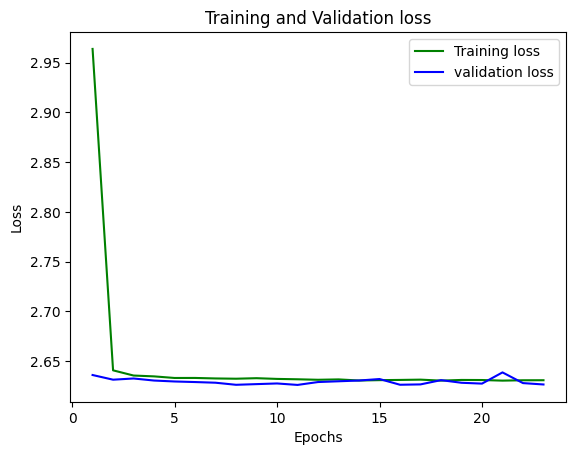

In [ ]:
loss_train = history_kl.history['loss']
loss_val = history_kl.history['val_loss']
epochs = range(1,24)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

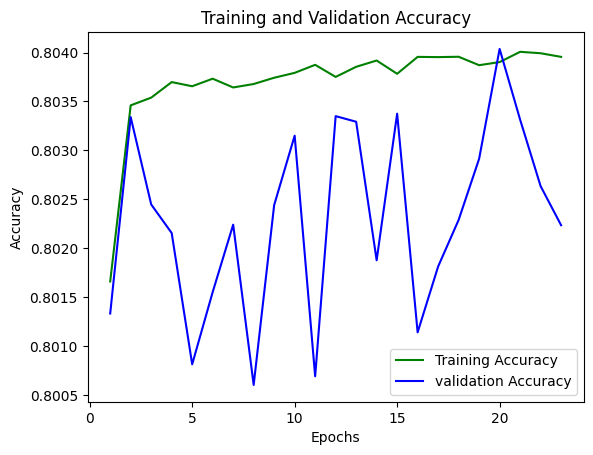

In [ ]:
acc_train = history_kl.history['accuracy']
acc_val = history_kl.history['val_accuracy']
epochs = range(1,24)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
sample_kl = [np.random.multivariate_normal([0] * latent_size, np.diag([1] * latent_size), 20)] * 3

In [ ]:
generated_kl = vlae_kl.get_layer('decoder').predict(sample)

1/1 [==============================] - 1s 679ms/step


In [ ]:
generated_kl = generated_kl.reshape((20, 28, 28))

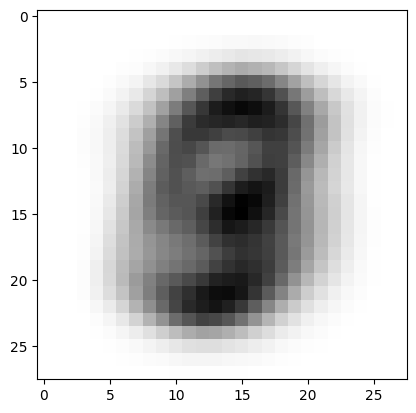

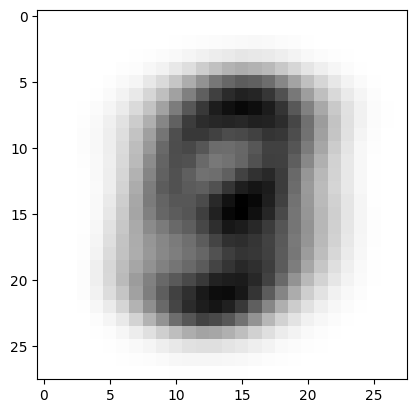

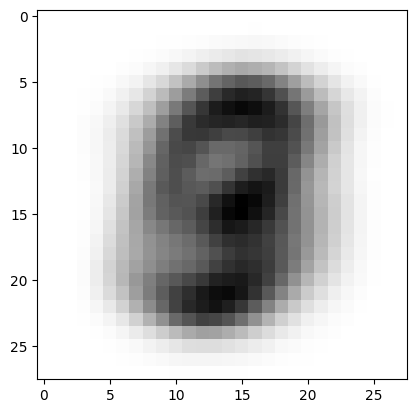

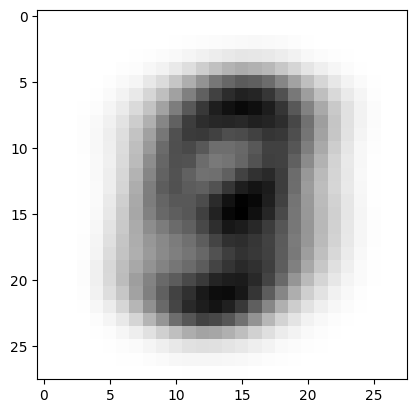

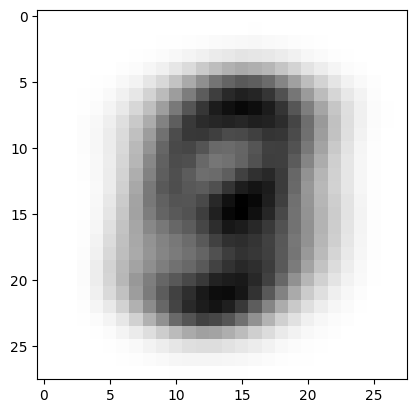

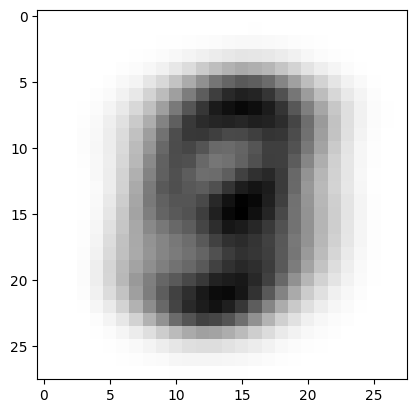

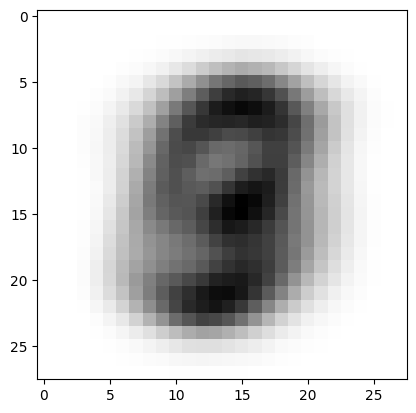

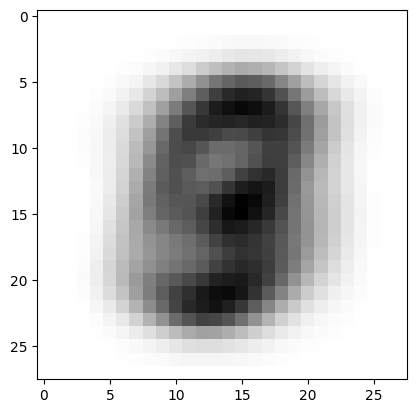

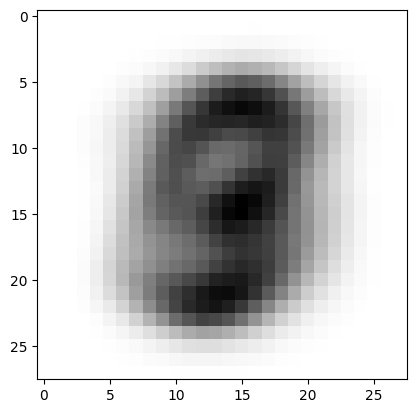

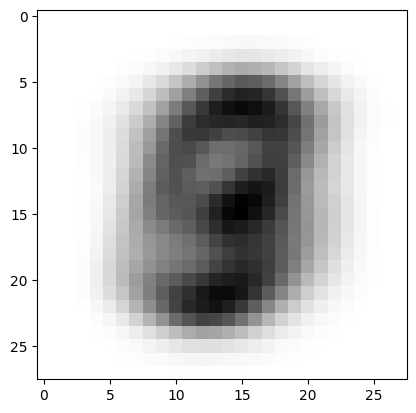

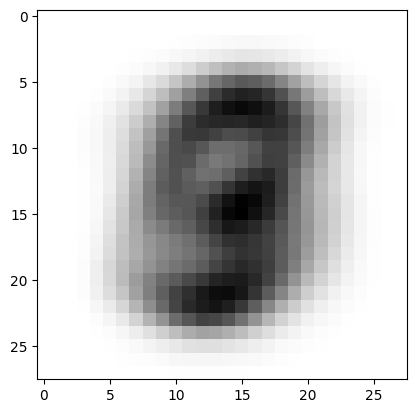

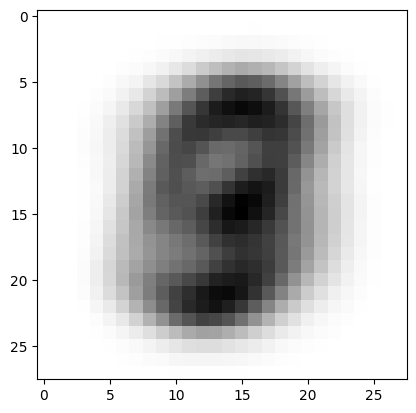

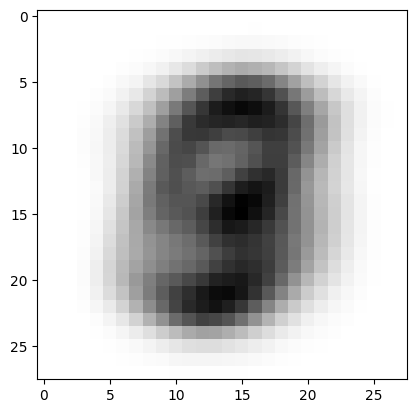

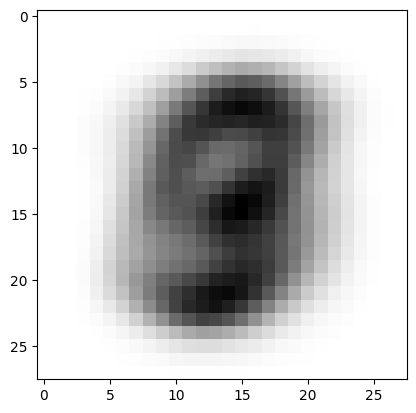

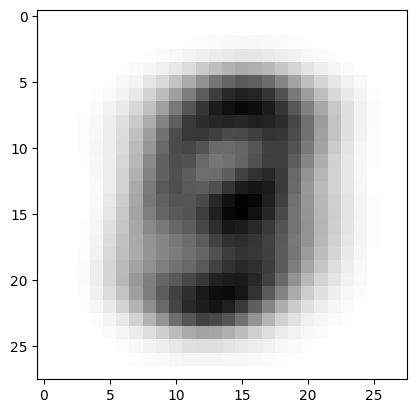

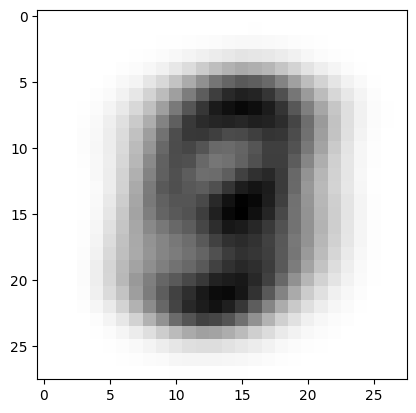

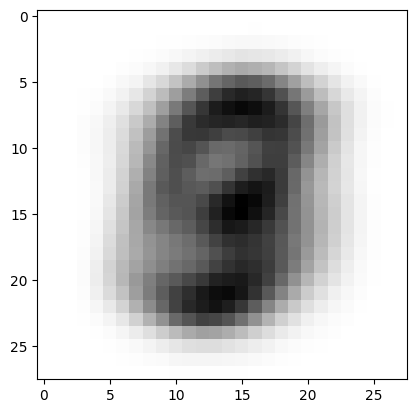

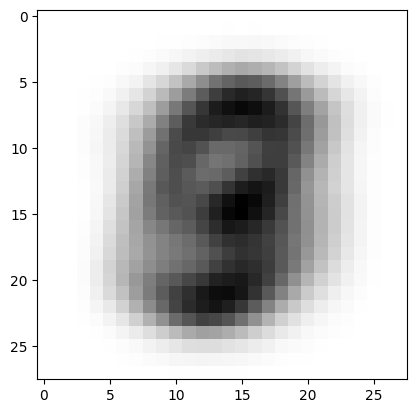

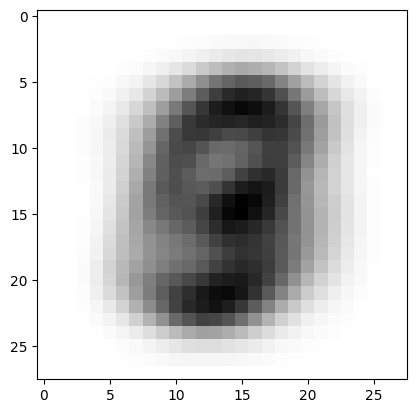

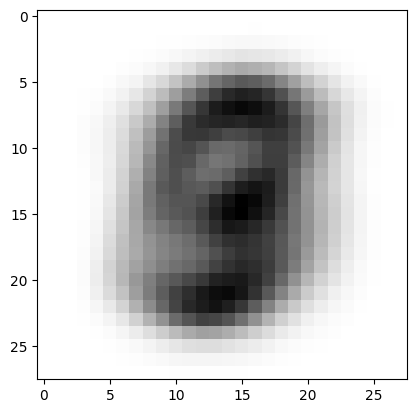

In [ ]:
for i in range(20):
    img = generated_kl[i, :, :]
    plt.imshow(img, cmap='gray_r')
    plt.show()